In [4]:
import scipy
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
import typing as tp
import parmap # need to install parmap
import anndata
from tqdm import tqdm


def z_score(x):
    """
    Scale (divide by standard deviation) and center (subtract mean) 
    array-like objects.
    """
    return (x - x.min()) / (x.max() - x.min())

def sparse_matrix_dstack(
    matrices: tp.Sequence[scipy.sparse.csr_matrix],
) -> scipy.sparse.csr_matrix:
    """
    Diagonally stack sparse matrices.
    """

    n = sum([x.shape[0] for x in matrices])
    _res = list()
    i = 0
    for x in matrices:
        v = scipy.sparse.csr_matrix((x.shape[0], n))
        v[:, i : i + x.shape[0]] = x
        _res.append(v)
        i += x.shape[0]
    return scipy.sparse.vstack(_res)

def _parallel_message_pass(
    ad,
    radius: int,
    coord_type: str,
    set_diag: bool,
    mode: str,
):
    sq.gr.spatial_neighbors(ad, radius=radius, coord_type=coord_type, 
                            set_diag=set_diag)
    ad = custom_message_passing(ad, mode=mode)
    return ad


def custom_message_passing(adata, mode: str = "l1_norm"):
    # from scipy.linalg import sqrtm
    # import logging
    if mode == "l1_norm":
        A = adata.obsp["spatial_connectivities"]
        from sklearn.preprocessing import normalize
        affinity = normalize(A, axis=1, norm="l1")
    else:
        # Plain A_mod multiplication
        A = adata.obsp["spatial_connectivities"]
        affinity = A
    # logging.info(type(affinity))
    adata.X = affinity @ adata.X
    return adata


def low_variance_filter(adata):
    return adata[:, adata.var["std"] > adata.var["std"].median()]


def add_probabilities_to_centroid(
    adata, col: str, name_to_output: str = None
):
    from scipy.special import softmax

    if name_to_output is None:
        name_to_output = col + "_probabilities"

    mean = z_score(adata.to_df()).groupby(adata.obs[col]).mean()
    probs = softmax(adata.to_df() @ mean.T, axis=1)
    adata.obsm[name_to_output] = probs
    return adata

def utag(
    adata,
    channels_to_use = None,
    slide_key = "Slide",
    save_key: str = "UTAG Label",
    filter_by_variance: bool = False,
    max_dist: float = 20.0,
    normalization_mode: str = "l1_norm",
    keep_spatial_connectivity: bool = False,
    n_pcs = 10,
    apply_umap: bool = False,
    umap_kwargs: tp.Dict[str, tp.Any] = dict(),
    apply_clustering: bool = True,
    clustering_method: tp.Sequence[str] = ["leiden"],
    resolutions: tp.Sequence[float] = [0.05, 0.1, 0.3, 1.0],
    leiden_kwargs: tp.Dict[str, tp.Any] = None,
    parc_kwargs: tp.Dict[str, tp.Any] = None,
    parallel: bool = False,
    processes: int = 1,
    k=15,
    random_state=42,
):
    """
    Discover tissue architechture in single-cell imaging data
    by combining phenotypes and positional information of cells.

    Parameters
    ----------
    adata: AnnData
        AnnData object with spatial positioning of cells in obsm 'spatial' slot.
    channels_to_use: Optional[Sequence[str]]
        An optional sequence of strings used to subset variables to use.
        Default (None) is to use all variables.
    max_dist: float
        Maximum distance to cut edges within a graph.
        Should be adjusted depending on resolution of images.
        For imaging mass cytometry, where resolution is 1um, 20 often 
        gives good results. Default is 20.
    slide_key: {str, None}
        Key of adata.obs containing information on the batch structure 
        of the data. In general, for image data this will often be a variable 
        indicating the image so image-specific effects are removed from data.
        Default is "Slide".
    save_key: str
        Key to be added to adata object holding the UTAG clusters.
        Depending on the values of `clustering_method` and `resolutions`,
        the final keys will be of the form: {save_key}_{method}_{resolution}".
        Default is "UTAG Label".
    filter_by_variance: bool
        Whether to filter vairiables by variance.
        Default is False, which keeps all variables.
    max_dist: float
        Recommended values are between 20 to 50 depending on magnification.
        Default is 20.
    normalization_mode: str
        Method to normalize adjacency matrix.
        Default is "l1_norm", any other value will not use normalization.
    keep_spatial_connectivity: bool
        Whether to keep sparse matrices of spatial connectivity and distance 
        in the obsp attribute of the resulting anndata object. This could be 
        useful in downstream applications.
        Default is not to (False).
    pca_kwargs: Dict[str, Any]
        Keyword arguments to be passed to scanpy.pp.pca for dimensionality 
        reduction after message passing.
        Default is to pass n_comps=10, which uses 10 Principal Components.
    apply_umap: bool
        Whether to build a UMAP representation after message passing.
        Default is False.
    umap_kwargs: Dict[str, Any]
        Keyword arguments to be passed to scanpy.tl.umap for dimensionality 
        reduction after message passing. Default is 10.0.
    apply_clustering: bool
        Whether to cluster the message passed matrix.
        Default is True.
    clustering_method: Sequence[str]
        Which clustering method(s) to use for clustering of the 
        message passed matrix. Default is ["leiden"].
    resolutions: Sequence[float]
        What resolutions should the methods in `clustering_method` be run at.
        Default is [0.05, 0.1, 0.3, 1.0].
    leiden_kwargs: dict[str, Any]
        Keyword arguments to pass to scanpy.tl.leiden.
    parc_kwargs: dict[str, Any]
        Keyword arguments to pass to parc.PARC.
    parallel: bool
        Whether to run message passing part of algorithm in parallel.
        Will accelerate the process but consume more memory.
        Default is True.
    processes: int
        Number of processes to use in parallel.
        Default is to use all available (-1).

    Returns
    -------
    adata: AnnData
        AnnData object with UTAG domain predictions for each cell in adata.obs,
        column `save_key`.
    """
    ad = adata.copy()

    if channels_to_use:
        ad = ad[:, channels_to_use]

    if filter_by_variance:
        ad = low_variance_filter(ad)

    if isinstance(clustering_method, list):
        clustering_method = [m.upper() for m in clustering_method]
    elif isinstance(clustering_method, str):
        clustering_method = [clustering_method.upper()]
    else:
        print(
            """Invalid Clustering Method. Clustering Method Should Either be 
            a string or a list"""
        )
        return
    assert all(m in ["LEIDEN", "KMEANS"] for m in clustering_method)

    if "KMEANS" in clustering_method:
        from sklearn.cluster import KMeans

    print("Applying UTAG Algorithm...")
    if slide_key:
        ads = [
            ad[ad.obs[slide_key] == slide].copy() for slide in ad.obs[slide_key].unique()
        ]
        ad_list = parmap.map(
            _parallel_message_pass,
            ads,
            radius=max_dist,
            coord_type="generic",
            set_diag=True,
            mode=normalization_mode,
            pm_pbar=True,
            pm_parallel=parallel,
            pm_processes=processes,
        )
        ad_result = anndata.concat(ad_list)
        if keep_spatial_connectivity:
            ad_result.obsp["spatial_connectivities"] = sparse_matrix_dstack(
                [x.obsp["spatial_connectivities"] for x in ad_list]
            )
            ad_result.obsp["spatial_distances"] = sparse_matrix_dstack(
                [x.obsp["spatial_distances"] for x in ad_list]
            )
    else:
        sq.gr.spatial_neighbors(ad, radius=max_dist, coord_type="generic", 
                                set_diag=True)
        ad_result = custom_message_passing(ad, mode=normalization_mode)

    if apply_clustering:
        # if "n_comps" in pca_kwargs:
        #     if pca_kwargs["n_comps"] > ad_result.shape[1]:
        #         pca_kwargs["n_comps"] = ad_result.shape[1] - 1
        #         print(
        #             f"Overwriding provided number of PCA dimensions to match number of features: {pca_kwargs['n_comps']}"
        #         )
        if n_pcs == 0:
            print("0 components")
            sc.pp.neighbors(ad_result, n_pcs=0, n_neighbors=k, random_state=random_state, use_rep="X")
        else:
            print("execute with principal components")
            sc.tl.pca(ad_result, n_comps=n_pcs)
            sc.pp.neighbors(ad_result, n_neighbors=k, n_pcs=n_pcs, random_state=random_state, use_rep='X_pca')

        if apply_umap:
            print("Running UMAP on Input Dataset...")
            sc.tl.umap(ad_result, **umap_kwargs)

        for resolution in resolutions:

            res_key1 = save_key + "_leiden_" + str(resolution)
            res_key3 = save_key + "_kmeans_" + str(resolution)
            if "LEIDEN" in clustering_method:
                print(f"Applying Leiden Clustering at Resolution: {resolution}...")
                kwargs = dict()
                kwargs.update(leiden_kwargs or {})
                sc.tl.leiden(
                    ad_result, resolution=resolution, key_added=res_key1, **kwargs
                )
                add_probabilities_to_centroid(ad_result, res_key1)

            if "KMEANS" in clustering_method:
                print(f"Applying K-means Clustering at Resolution: {resolution}...")
                k = int(np.ceil(resolution * 10))
                kmeans = KMeans(n_clusters=k, random_state=1).fit(ad_result.obsm["X_pca"])
                ad_result.obs[res_key3] = pd.Categorical(kmeans.labels_.astype(str))
                add_probabilities_to_centroid(ad_result, res_key3)

    return ad_result

/Users/bombina2/miniconda3/envs/spac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import multiprocessing
multiprocessing.set_start_method('fork', force=True)

def run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=1,
        max_dist=20,
        n_pcs=10,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key="Slide",
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel=False,
        **kwargs
):
    """
    Run UTAG clustering on the AnnData object.

    Parameters
    ----------
    adata : anndata.AnnData
        The AnnData object.
    features : list
        List of features to use for clustering or for PCA. Default 
        (None) is to use all.
    k : int
        The number of nearest neighbor to be used in creating the graph.
        Default is 15.
    resolution : float
        Resolution parameter for the clustering, higher resolution produces 
        more clusters. Default is 1.
    max_dist : float
        Maximum distance to cut edges within a graph. Default is 20.
    n_principal_components : int
        Number of principal components to use for clustering.
    random_state : int
        Random state for reproducibility.
    n_jobs : int
        Number of jobs to run in parallel. Default is 5.
    n_iterations : int
        Number of iterations for the clustering.
    slide_key: str
        Key of adata.obs containing information on the batch structure 
        of the data.In general, for image data this will often be a variable 
        indicating the imageb so image-specific effects are removed from data.
        Default is "Slide".

    Returns
    -------
    adata : anndata.AnnData
        Updated AnnData object with clustering results.
    """
    resolutions = [resolution]
    
    
    if not isinstance(k, int) or k <= 0:
        raise ValueError("`k` must be a positive integer")

    if random_state is not None:
        np.random.seed(random_state)

    adata_utag = adata.copy()
    
    utag_results = utag(
        adata_utag,
        slide_key=slide_key,
        max_dist=max_dist,
        normalization_mode='l1_norm',
        apply_clustering=True,
        clustering_method="leiden",
        resolutions=resolutions,
        leiden_kwargs={"n_iterations": n_iterations, 
                       "random_state": random_state},
        n_pcs=n_pcs,
        parallel=parallel,
        processes=n_jobs,
        k=k,
    )

    curClusterCol = 'UTAG Label_leiden_' + str(resolution)
    cluster_list = utag_results.obs[curClusterCol].copy()
    adata.obs[output_annotation] = cluster_list.copy()
    adata.uns["utag_features"] = features

In [8]:
adata = sc.read("/Users/bombina2/github/multiplex-analysis-web-apps/input/healthy_lung_adata.h5ad")

run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=0.1,
        max_dist=20,
        n_pcs=0,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key="roi",
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#first_run_clusters = adata.obs['UTAG'].copy()
run1 = list(adata.obs["UTAG"].copy())

del adata
adata = sc.read("/Users/bombina2/github/multiplex-analysis-web-apps/input/healthy_lung_adata.h5ad")

run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=0.1,
        max_dist=20,
        n_pcs=0,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key="roi",
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#second_run_clusters = adata.obs['UTAG'].copy()
run2 = list(adata.obs["UTAG"].copy())

print(pd.unique(run1))
print(pd.unique(run2))

run1 == run2


Applying UTAG Algorithm...


100%|██████████| 26/26 [00:00<00:00, 31.03it/s]


0 components
Applying Leiden Clustering at Resolution: 0.1...
Applying UTAG Algorithm...


100%|██████████| 26/26 [00:00<00:00, 31.01it/s]


0 components
Applying Leiden Clustering at Resolution: 0.1...
['5' '0' '2' '1' '3' '6' '8' '4' '7' '11' '10' '12' '9']
['5' '0' '2' '1' '3' '6' '8' '4' '7' '11' '10' '12' '9']


True

In [52]:
adata = sc.read("/Users/bombina2/github/multiplex-analysis-web-apps/input/healthy_lung_adata.h5ad")

run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=0.5,
        max_dist=20,
        n_pcs=0,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key='roi',
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#first_run_clusters = adata.obs['UTAG'].copy()
run1 = list(adata.obs["UTAG"].copy())

del adata.obs["UTAG"]
#adata = sc.read("/Users/bombina2/github/multiplex-analysis-web-apps/input/healthy_lung_adata.h5ad")

run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=0.5,
        max_dist=20,
        n_pcs=10,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key='roi',
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#second_run_clusters = adata.obs['UTAG'].copy()
run2 = list(adata.obs["UTAG"].copy())
print(pd.unique(run1))
print(pd.unique(run2))

run1 == run2

Applying UTAG Algorithm...


100%|██████████| 26/26 [00:00<00:00, 30.65it/s]


0 components
Applying Leiden Clustering at Resolution: 0.5...
Applying UTAG Algorithm...


100%|██████████| 26/26 [00:00<00:00, 32.09it/s]


execute with principal components
Applying Leiden Clustering at Resolution: 0.5...
['17' '6' '7' '8' '2' '0' '9' '1' '19' '4' '30' '16' '13' '12' '11' '10'
 '15' '5' '23' '3' '21' '28' '40' '25' '36' '14' '20' '29' '22' '18' '37'
 '33' '27' '26' '35' '34' '24' '39' '38' '31' '32']
['3' '0' '2' '11' '7' '5' '10' '1' '15' '4' '9' '6' '8' '16' '14' '13'
 '17' '12' '18']


False

In [1]:
import numpy as np
import pandas as pd
import anndata
from sklearn.preprocessing import StandardScaler
import scanpy as sc

# Set random seed
np.random.seed(42)

# Number of cells
n_cells = 500

# Generate spatial coordinates in a circular pattern
theta = np.random.uniform(0, 2*np.pi, n_cells)
r = np.random.uniform(0, 10, n_cells)
x_coord = r * np.cos(theta)
y_coord = r * np.sin(theta)

# Create non-linear gene expression patterns based on spatial location
# Gene 1-2: Expression based on radial distance
# Gene 3-4: Expression based on angular position
# Gene 5-6: Expression based on quadrant location
# Gene 7-8: Random noise genes

# Radial distance-dependent genes (higher expression at the periphery)
gene1 = np.exp(r/5) + np.random.normal(0, 0.5, n_cells)
gene2 = -np.exp(r/5) + np.random.normal(0, 0.5, n_cells)

# Angular position-dependent genes (periodic pattern)
gene3 = np.sin(3*theta) + np.random.normal(0, 0.3, n_cells)
gene4 = np.cos(3*theta) + np.random.normal(0, 0.3, n_cells)

# Quadrant-specific genes
quadrant = np.where((x_coord > 0) & (y_coord > 0), 1,
                   np.where((x_coord < 0) & (y_coord > 0), 2,
                           np.where((x_coord < 0) & (y_coord < 0), 3, 4)))
gene5 = np.where(np.isin(quadrant, [1, 2]), 3, 0) + np.random.normal(0, 0.3, n_cells)
gene6 = np.where(np.isin(quadrant, [1, 4]), 3, 0) + np.random.normal(0, 0.3, n_cells)

# Random noise genes
gene7 = np.random.normal(0, 1, n_cells)
gene8 = np.random.normal(0, 1, n_cells)

# Combine all genes
expression_matrix = np.column_stack([gene1, gene2, gene3, gene4, gene5, gene6, gene7, gene8])

# Create AnnData object
adata = anndata.AnnData(
    X=expression_matrix,
    obs=pd.DataFrame(
        {
            'spatial_x': x_coord,
            'spatial_y': y_coord,
            'quadrant': quadrant
        },
        index=[f'cell_{i}' for i in range(n_cells)]
    ),
    var=pd.DataFrame(
        {
            'gene_type': ['radial', 'radial', 'angular', 'angular', 
                         'quadrant', 'quadrant', 'random', 'random']
        },
        index=[f'gene_{i}' for i in range(8)]
    )
)

# Add raw counts layer (here our main matrix is already "normalized")
adata.layers['counts'] = expression_matrix.copy()

# Compute clustering using raw features
# sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
# sc.tl.leiden(adata, key_added='clusters_raw')

# # Compute PCA and clustering using PCA
# sc.pp.pca(adata)
# sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca', n_pcs=2)
# sc.tl.leiden(adata, key_added='clusters_pca')

# print("AnnData object shape:", adata.shape)
# print("\nGene types:", adata.var['gene_type'].value_counts())
# print("\nNumber of clusters (raw):", len(np.unique(adata.obs['clusters_raw'])))
# print("Number of clusters (PCA):", len(np.unique(adata.obs['clusters_pca'])))

/var/folders/l6/zgn1g2bj5d7d8fcqntg3rd10cvxym5/T/ipykernel_32525/486830865.py:48: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(


In [10]:
#adata.obsm["spatial"] = adata.X[:, 2:4]
adata.obsm["spatial"] = np.random.rand(500, 500)
adata

first_part = np.full((250, 2), [1, 2])

# Create the next 250 rows with values 3 and 4
second_part = np.full((250, 2), [3, 4])

# Combine both parts to form a (500, 2) array
final_array = np.vstack([first_part, second_part])

# adata.obsm["spatial"] = final_array



In [13]:
run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=1,
        max_dist=2,
        n_pcs=0,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key=None,
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#first_run_clusters = adata.obs['UTAG'].copy()
run1 = list(adata.obs["UTAG"].copy())

del adata.obs["UTAG"]
#adata = sc.read("/Users/bombina2/github/multiplex-analysis-web-apps/input/healthy_lung_adata.h5ad")

run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=1,
        max_dist=2,
        n_pcs=2,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key=None,
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#second_run_clusters = adata.obs['UTAG'].copy()
run2 = list(adata.obs["UTAG"].copy())
print(pd.unique(run1))
print(pd.unique(run2))

run1 == run2

Applying UTAG Algorithm...
0 components
Applying Leiden Clustering at Resolution: 1...
Applying UTAG Algorithm...
execute with principal components
Applying Leiden Clustering at Resolution: 1...
['8' '0' '2' '4' '7' '3' '6' '5' '1']
['0' '1' '4' '3' '7' '11' '10' '12' '13' '9' '8' '2' '6' '5']


False

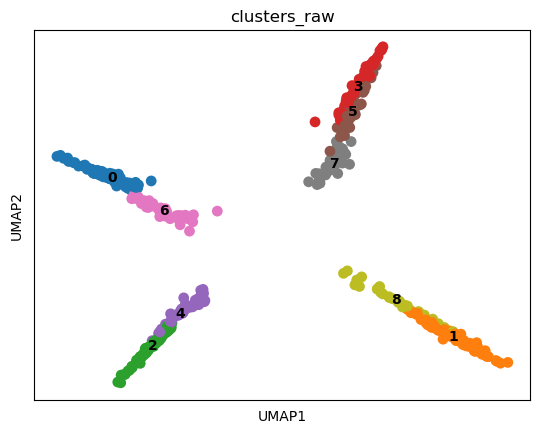

In [58]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata, key_added='clusters_raw')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters_raw', legend_loc='on data')

In [45]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc

# Set random seed
np.random.seed(42)

# Number of cells per cluster
n_cells_per_cluster = 250
n_cells = n_cells_per_cluster * 2

# Generate spatial coordinates in two distinct circular patterns
# Cluster 1: Centered at (0, 0)
theta1 = np.random.uniform(0, 2*np.pi, n_cells_per_cluster)
r1 = np.random.uniform(0, 3, n_cells_per_cluster)
x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

# Cluster 2: Centered at (10, 10)
theta2 = np.random.uniform(0, 2*np.pi, n_cells_per_cluster)
r2 = np.random.uniform(0, 3, n_cells_per_cluster)
x2 = 10 + r2 * np.cos(theta2)
y2 = 10 + r2 * np.sin(theta2)

# Combine coordinates
x_coord = np.concatenate([x1, x2])
y_coord = np.concatenate([y1, y2])
r = np.concatenate([r1, r2])
theta = np.concatenate([theta1, theta2])
spatial_clusters = np.array(['cluster1']*n_cells_per_cluster + ['cluster2']*n_cells_per_cluster)

# Create non-linear gene expression patterns
# Gene 1-2: Expression based on radial distance
# Gene 3-4: Expression based on angular position
# Gene 5-6: Expression based on spatial cluster
# Gene 7-8: Random noise genes

# Radial distance-dependent genes
gene1 = np.exp(r/2) + np.random.normal(0, 0.5, n_cells)
gene2 = -np.exp(r/2) + np.random.normal(0, 0.5, n_cells)

# Angular position-dependent genes
gene3 = np.sin(3*theta) + np.random.normal(0, 0.3, n_cells)
gene4 = np.cos(3*theta) + np.random.normal(0, 0.3, n_cells)

# Cluster-specific genes (different expression in each spatial cluster)
gene5 = np.where(spatial_clusters == 'cluster1', 3, 0) + np.random.normal(0, 0.3, n_cells)
gene6 = np.where(spatial_clusters == 'cluster2', 3, 0) + np.random.normal(0, 0.3, n_cells)

# Random noise genes
gene7 = np.random.normal(0, 1, n_cells)
gene8 = np.random.normal(0, 1, n_cells)

# Combine all genes
expression_matrix = np.column_stack([gene1, gene2, gene3, gene4, gene5, gene6, gene7, gene8])

# Create AnnData object
adata = anndata.AnnData(
    X=expression_matrix,
    obs=pd.DataFrame(
        {
            'spatial_x': x_coord,
            'spatial_y': y_coord,
            'spatial_cluster': spatial_clusters
        },
        index=[f'cell_{i}' for i in range(n_cells)]
    ),
    var=pd.DataFrame(
        {
            'gene_type': ['radial', 'radial', 'angular', 'angular', 
                         'spatial', 'spatial', 'random', 'random']
        },
        index=[f'gene_{i}' for i in range(8)]
    )
)

# Add raw counts layer

adata.layers['counts'] = expression_matrix.copy()
adata.obsm['spatial'] = np.array(adata.obs[["spatial_x", "spatial_y"]])
adata

/var/folders/l6/zgn1g2bj5d7d8fcqntg3rd10cvxym5/T/ipykernel_27119/1961125387.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(


AnnData object with n_obs × n_vars = 500 × 8
    obs: 'spatial_x', 'spatial_y', 'spatial_cluster'
    var: 'gene_type'
    obsm: 'spatial'
    layers: 'counts'

In [50]:
del adata.obsm['spatial'] 
first_two_genes = adata.X[:, :2]
len(first_two_genes)
adata.obsm['spatial'] = first_two_genes.copy()

In [6]:
run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=1,
        max_dist=20,
        n_pcs=0,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key=None,
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#first_run_clusters = adata.obs['UTAG'].copy()
run1 = list(adata.obs["UTAG"].copy())

del adata.obs["UTAG"]
#adata = sc.read("/Users/bombina2/github/multiplex-analysis-web-apps/input/healthy_lung_adata.h5ad")

run_utag_clustering(
        adata,
        features=None,
        k=15,
        resolution=1,
        max_dist=20,
        n_pcs=2,
        random_state=42,
        n_jobs=1,
        n_iterations=5,
        slide_key=None,
        layer=None,
        output_annotation="UTAG",
        associated_table=None,
        parallel = False)

#second_run_clusters = adata.obs['UTAG'].copy()
run2 = list(adata.obs["UTAG"].copy())
print(pd.unique(run1))
print(pd.unique(run2))

run1 == run2

Applying UTAG Algorithm...
0 components
Applying Leiden Clustering at Resolution: 1...
Applying UTAG Algorithm...
execute with principal components
Applying Leiden Clustering at Resolution: 1...
['0']
['0']


True